In [1565]:
from reliability.Distributions import Weibull_Distribution
from reliability.Fitters import Fit_Weibull_2P
from reliability.Probability_plotting import plot_points, plotting_positions, Weibull_probability_plot
from reliability.Utils import axes_transforms, probability_plot_xylims, probability_plot_xyticks

import matplotlib.pyplot as plt
from matplotlib import ticker, colors, colormaps
import pandas as pd
from matplotlib.figure import figaspect
import seaborn as sns
import numpy as np
import string

# Example

Results from Fit_Weibull_2P (95% CI):
Analysis method: Least Squares Estimation (RRX)
Failures / Right censored: 20/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         28.1297          3.6749   21.7752   36.3385
     Beta         1.80611        0.316663   1.28087   2.54674 

Goodness of fit    Value
 Log-likelihood  -79.565
           AICc  163.836
            BIC  165.121
             AD 0.817695 



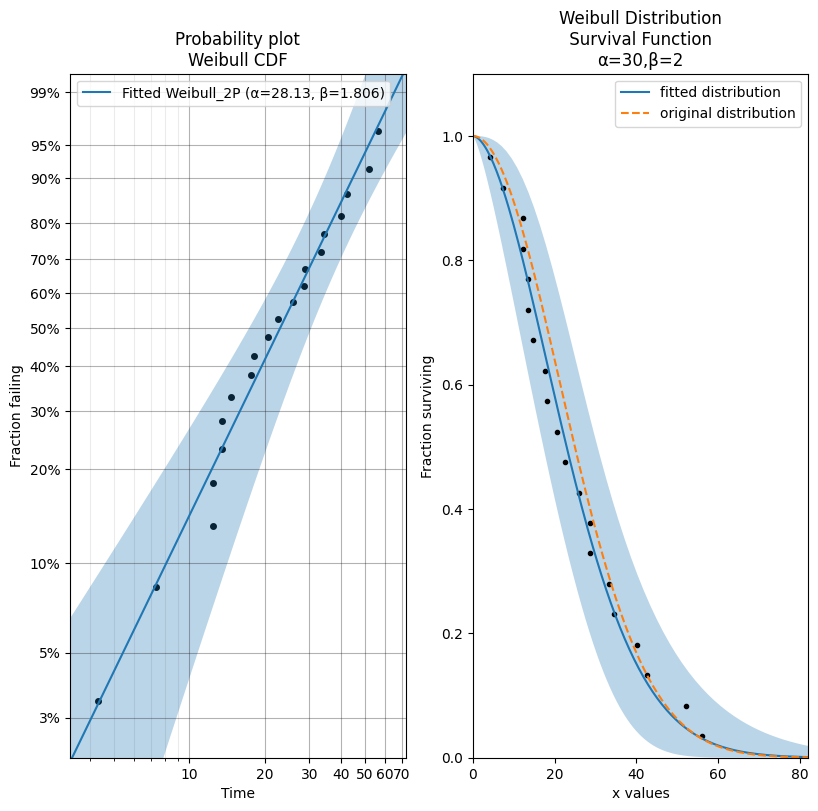

In [1566]:
example_dist = Weibull_Distribution(alpha=30, beta=2)  # creates the distribution object
example_data = example_dist.random_samples(20, seed=42)  # draws 20 samples from the distribution. Seeded for repeatability
plt.subplot(121)
fit = Fit_Weibull_2P(failures=example_data, method="LS")  # fits a Weibull distribution to the data and generates the probability plot
plt.subplot(122)
fit.distribution.SF(label='fitted distribution')  # uses the distribution object from Fit_Weibull_2P and plots the survival function
example_dist.SF(label='original distribution', linestyle='--') # plots the survival function of the original distribution
plot_points(failures=example_data, func='SF')  # overlays the original data on the survival function
plt.legend()
plt.show()

In [1567]:
example_data

array([20.55094355, 52.04910458, 34.42486201, 28.66440822, 12.355662  ,
       12.35462111,  7.33858922, 42.54536142, 28.76063174, 33.28851237,
        4.32658956, 56.15337681, 40.09721423, 14.65670027, 13.43916254,
       13.50371358, 18.06871209, 25.87537532, 22.56065957, 17.60115602])

# 3.5mm Sample Test

In [1568]:
test_data = pd.read_csv("Test_data.csv")

test_data

,Unnamed: 0,Proben-Nr.,Datum/Uhrzeit,Fcr,...,Moment,failure stress,Unnamed: 10,Diameter.1
0,NaN,NaN,NaN,N,...,Nmm,N/mm^2,NaN,mm
1,Probe 1,1,45420.6,22.85162354,...,342.8,76.7,NaN,3.57
2,Probe 2,2,45420.7,22.49817848,...,337.5,74.9,NaN,3.58
3,Probe 3,3,45420.7,18.44078827,...,276.6,62.4,NaN,3.56
4,Probe 4,4,45420.7,22.20804024,...,333.1,79.8,NaN,3.49
5,Probe 5,5,45420.7,23.90054512,...,358.5,83.7,NaN,3.52
6,Probe 6,6,45420.7,25.65187645,...,384.8,87.6,NaN,3.55
7,Probe 7,7,45420.7,26.03781509,...,390.6,87.4,NaN,3.57
8,Probe 8,8,45420.7,26.57203484,...,398.6,93.1,NaN,3.52
9,Probe 9,9,45420.7,18.93573761,...,284.0,65.8,NaN,3.53


In [1569]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(test_data):
    # Drop columns: 'Unnamed: 0', 'Unnamed: 10'
    test_data = test_data.drop(columns=['Unnamed: 0', 'Unnamed: 10'])
    # Drop rows with missing data in column: 'Proben-Nr.'
    test_data = test_data.dropna(subset=['Proben-Nr.'])
    # Change column type to uint32 for column: 'Proben-Nr.'
    test_data = test_data.astype({'Proben-Nr.': 'uint32'})
    # Rename column 'Proben-Nr.' to 'Probe_Num'
    test_data = test_data.rename(columns={'Proben-Nr.': 'Probe_Num'})
    return test_data

test_data_clean = clean_data(test_data.copy())
test_data_clean.head()

,Probe_Num,Datum/Uhrzeit,Fcr,Diameter,...,span,Moment,failure stress,Diameter.1
1,1,45420.6,22.85162354,3.57,...,30.0,342.8,76.7,3.57
2,2,45420.7,22.49817848,3.58,...,30.0,337.5,74.9,3.58
3,3,45420.7,18.44078827,3.56,...,30.0,276.6,62.4,3.56
4,4,45420.7,22.20804024,3.49,...,30.0,333.1,79.8,3.49
5,5,45420.7,23.90054512,3.52,...,30.0,358.5,83.7,3.52


In [1570]:
test_fail_data = test_data_clean['failure stress'].to_numpy(dtype="float32")
test_fail_data

array([ 76.7,  74.9,  62.4,  79.8,  83.7,  87.6,  87.4,  93.1,  65.8,
        71.2,  71.6,  89.5, 101.6, 105. ,  74.3,  78. ,  92. ,  94.6,
        81.5,  73.4,  79. ,  89.7,  83.6,  86.5, 115.6,  81.6,  60.4,
        87.8,  86.3, 102. ,  72.4,  85.9], dtype=float32)

Results from Fit_Weibull_2P (95% CI):
Analysis method: Least Squares Estimation (RRY)
Failures / Right censored: 32/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         88.6653         2.15064   84.5487   92.9823
     Beta         7.99328        0.968069   6.30428   10.1348 

Goodness of fit    Value
 Log-likelihood -127.807
           AICc  260.028
            BIC  262.546
             AD  1.07659 



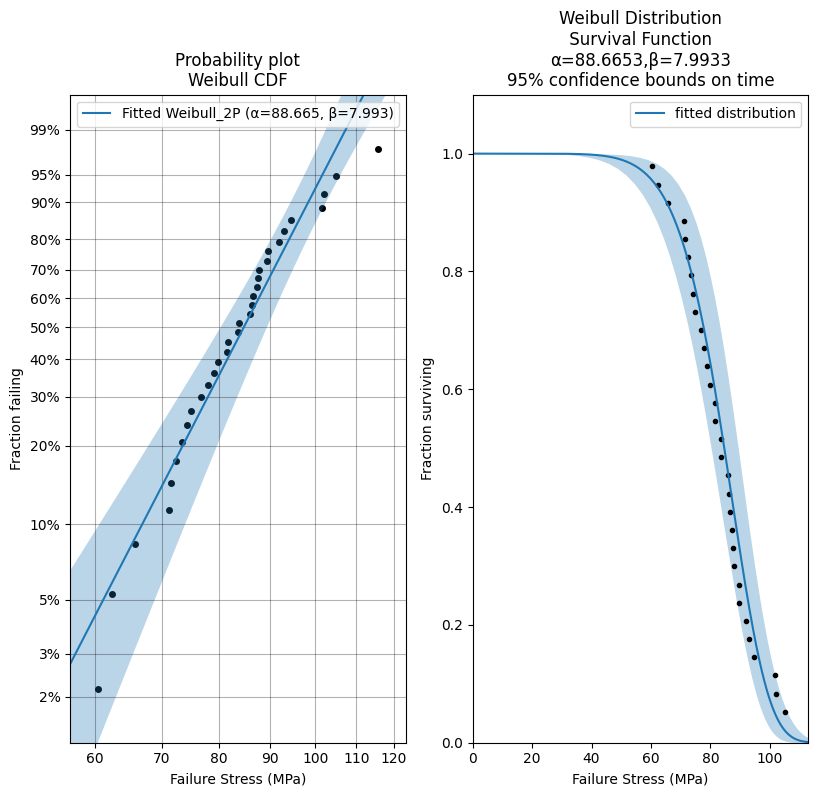

In [1571]:
plt.clf()
plt.subplot(121)
test_fit = Fit_Weibull_2P(failures=test_fail_data, method="LS")  # fits a Weibull distribution to the data and generates the probability plot
plt.xlabel("Failure Stress (MPa)")
plt.subplot(122)
test_fit.distribution.SF(label='fitted distribution')  # uses the distribution object from Fit_Weibull_2P and plots the survival function
plot_points(failures=test_fail_data, func='SF')  # overlays the original data on the survival function
plt.legend()
plt.xlabel("Failure Stress (MPa)")
plt.show()

In [1572]:
test_fail_data

array([ 76.7,  74.9,  62.4,  79.8,  83.7,  87.6,  87.4,  93.1,  65.8,
        71.2,  71.6,  89.5, 101.6, 105. ,  74.3,  78. ,  92. ,  94.6,
        81.5,  73.4,  79. ,  89.7,  83.6,  86.5, 115.6,  81.6,  60.4,
        87.8,  86.3, 102. ,  72.4,  85.9], dtype=float32)

In [1573]:
val_test = -8

test_fail_data[val_test]

np.float32(115.6)

In [1574]:
cdf_test = test_fit.distribution.CDF(xvals=[test_fail_data[val_test]], show_plot=False) ## Calculates values along the line

print(test_fail_data[val_test], " ", cdf_test)

115.6   0.9997598194127818


In [1575]:
test_points = plotting_positions(test_fail_data) ## Calculates where the points on the scatter should go

print(test_points[0][val_test], " ", test_points[1][val_test])

115.5999984741211   0.9783950617283951


# Load in and clean data

In [1576]:
gcc_data = pd.read_csv("Maple Rod Testing Analysis.csv")

gcc_data

,sample,fracture_load,fracture_stress,fracture_diameter,support_span,load_span,surface_area,volume
0,B1,46.7887,67.761,5.23,185,70,3039.65,3974.34
1,B2,85.8979,170.977,5.28,185,70,3068.71,4050.69
2,B3,54.1228,102.886,5.3,185,70,3080.33,4081.44
3,B4,64.6418,122.189,5.31,185,70,3086.14,4096.86
4,B5,78.9588,174.763,5.09,185,70,2958.28,3764.41
5,B6,57.2761,116.623,5.18,185,70,3010.59,3898.71
6,B7,68.1001,128.726,5.31,185,70,3086.14,4096.86
7,B8,80.9788,162.4,5.24,185,70,3045.46,3989.55
8,B9,56.073,108.539,5.22,185,70,3033.84,3959.16
9,B10,92.3955,179.794,5.32,185,70,3091.96,4112.3


In [1577]:
stiff_data = pd.read_csv("Stiffness\\Rod_stiffness_20250317-1030.csv")

stiff_data

,sample,stiff_slope,stiff_intercept,stiff_rvalue,stiff_rsquared,stiff_stderr,stiff_intercept_stderr
0,F1,1175.09,-5107.11,0.994105,0.988245,6.87005,38.4487
1,F2,1580.02,-8504.05,0.999495,0.99899,1.54694,10.7085
2,F3,1526.92,-7088.74,0.99948,0.99896,1.68071,10.0769
3,F4,2221.75,-10994.2,0.99756,0.995125,6.47367,38.0755
4,E1,443.757,-1838.61,0.996717,0.993445,1.68249,9.77643
5,E2,453.549,-1891.4,0.995984,0.991984,1.90922,11.0532
6,E3,598.983,-2739.42,0.995609,0.991238,2.09437,12.5437
7,E4,475.373,-1916.99,0.997402,0.994811,1.63854,9.16929
8,X1,372.65,-1544.1,0.998809,0.99762,0.592744,3.76905
9,X2,451.289,-1990.15,0.997132,0.994272,1.47,8.98928


In [1578]:
gcc_data = pd.merge(gcc_data, stiff_data, on="sample")

In [1579]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(gcc_data):
    # Drop rows with missing data in column: 'fracture_stress'
    gcc_data = gcc_data.dropna(subset=['fracture_stress'])
    return gcc_data

gcc_data_clean = clean_data(gcc_data.copy())
gcc_data_clean.head()

,sample,fracture_load,fracture_stress,fracture_diameter,...,stiff_rvalue,stiff_rsquared,stiff_stderr,stiff_intercept_stderr
0,B1,46.7887,67.761,5.23,...,0.999346,0.998693,0.017214,0.0434286
1,B2,85.8979,170.977,5.28,...,0.999592,0.999184,0.0146036,0.0692124
2,B3,54.1228,102.886,5.3,...,0.999528,0.999056,0.0178639,0.0592741
3,B4,64.6418,122.189,5.31,...,0.999602,0.999203,0.0155251,0.0547607
4,B5,78.9588,174.763,5.09,...,0.999707,0.999414,0.0179146,0.0794565


In [1580]:
gcc_data_clean["series"] = gcc_data_clean["sample"].str[0] ## Extract series letter from the "sample" column

gcc_data_clean = gcc_data_clean.drop(gcc_data_clean[gcc_data_clean["sample"] == "D5"].index) ## Drop this outlier for now, remember to determine if this needs further inspection

gcc_data_clean

,sample,fracture_load,fracture_stress,fracture_diameter,...,stiff_rsquared,stiff_stderr,stiff_intercept_stderr,series
0,B1,46.7887,67.761,5.23,...,0.998693,0.017214,0.0434286,B
1,B2,85.8979,170.977,5.28,...,0.999184,0.0146036,0.0692124,B
2,B3,54.1228,102.886,5.3,...,0.999056,0.0178639,0.0592741,B
3,B4,64.6418,122.189,5.31,...,0.999203,0.0155251,0.0547607,B
4,B5,78.9588,174.763,5.09,...,0.999414,0.0179146,0.0794565,B
5,B6,57.2761,116.623,5.18,...,0.999184,0.0276003,0.0993303,B
6,B7,68.1001,128.726,5.31,...,0.999632,0.0168685,0.0582159,B
7,B8,80.9788,162.4,5.24,...,0.999428,0.0201934,0.082028,B
8,B9,56.073,108.539,5.22,...,0.999525,0.020953,0.0657883,B
9,B10,92.3955,179.794,5.32,...,0.999798,0.0119736,0.0576809,B


# Analyse Strength

## Functions

In [1581]:
def fit_and_plot_weibull(data):
    data_anal = data[["series", "fracture_diameter", "fracture_stress"]].groupby("series").agg(['mean', "std"])
    data_anal.columns = data_anal.columns.map('_'.join)
    data_anal["fracture_stress_CV"] = data_anal["fracture_stress_std"] / data_anal["fracture_stress_mean"] * 100
    
    unique_values = data["series"].unique()
    
    w, h = figaspect(1.2)

    fracture_prob = pd.DataFrame()

    ind_fig, ind_ax = plt.subplots()
    collated_fig, collated_ax = plt.subplots()

    collated_min_x = 100
    collated_max_x = 100

    for letter in unique_values:
        fracture_frame = data.loc[data["series"] == letter, ["fracture_stress"]].copy()
        plot_data = fracture_frame.squeeze(axis=1).to_numpy(dtype="float32")

        if len(plot_data) < 2: continue

        collated_min_x = min(np.min(plot_data), collated_min_x)
        collated_max_x = min(np.max(plot_data), collated_max_x)
        
        avg_diameter = data_anal.loc[letter, "fracture_diameter_mean"]
        legend_text = "%s series: ~%.2f mm" % (letter, avg_diameter)
        
        plt.sca(ind_ax)
        fracture_fit = Fit_Weibull_2P(failures=plot_data, print_results=False, label=legend_text, method="LS")  # fits a Weibull distribution to the data and generates the probability plot
    
        title_text = "Weibull probability\nScale= %.2f MPa  Shape= %.2f" % (fracture_fit.alpha, fracture_fit.beta)
        
        # fig = fracture_fit.probability_plot.get_figure()
        ind_fig.set_size_inches(7, 8)
        plt.ylabel("Probability of failure")
        plt.xlabel("Failure Stress (MPa)")
        plt.title(title_text)
        plt.legend()

        ind_fig.savefig("Figs/series_" + letter, bbox_inches = "tight")
        ind_ax.cla()

        fail_x, fail_y = plotting_positions(plot_data)

        fracture_frame.loc[:, "Fail Check"] = fail_x
        fracture_frame.loc[:, "Fail Prob"] = fail_y
        fracture_frame = fracture_frame.drop(["fracture_stress"], axis=1)

        fracture_prob =  pd.concat([fracture_prob, fracture_frame], axis=0)

        data_anal.loc[letter, "Alpha"] = fracture_fit.alpha
        data_anal.loc[letter, "Beta"] = fracture_fit.beta

        # collated_legend_text = "%s,$\\emptyset = %.2f$ mm, $\\alpha = %.2f$ MPa, $\\beta = %.2f$" % (letter, avg_diameter, fracture_fit.alpha, fracture_fit.beta)
        collated_legend_text = "%s, dia.= ~%.2f mm" % (letter, avg_diameter)

        plt.sca(collated_ax)
        Weibull_probability_plot(failures=plot_data, __fitted_dist_params=fracture_fit.distribution, show_scatter_points=False, CI_type=None, label=collated_legend_text)
        plt.title("")
        plt.ylabel("Probability of failure")
        plt.xlabel("Failure Stress (MPa)")

    ind_fig.clf()

    collated_fig.set_size_inches(7, 8)
    collated_ax.set_xlim([10, 300])
    collated_fig.savefig("Figs/collated", bbox_inches = "tight")
    data = pd.concat([data, fracture_prob], axis=1)

    return data, data_anal

## Run Analysis

<Figure size 700x800 with 0 Axes>

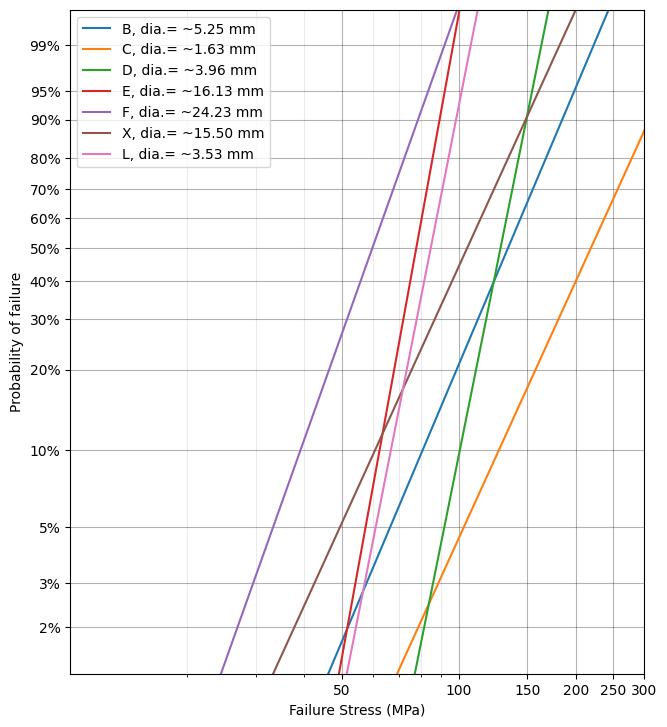

In [1582]:
gcc_data_clean, gcc_data_anal = fit_and_plot_weibull(gcc_data_clean)

In [1583]:
gcc_data_clean

,sample,fracture_load,fracture_stress,fracture_diameter,...,stiff_intercept_stderr,series,Fail Check,Fail Prob
0,B1,46.7887,67.761,5.23,...,0.0434286,B,67.761,0.0673077
1,B2,85.8979,170.977,5.28,...,0.0692124,B,170.977,0.740385
2,B3,54.1228,102.886,5.3,...,0.0592741,B,102.886,0.163462
3,B4,64.6418,122.189,5.31,...,0.0547607,B,122.189,0.451923
4,B5,78.9588,174.763,5.09,...,0.0794565,B,174.763,0.836538
5,B6,57.2761,116.623,5.18,...,0.0993303,B,116.623,0.355769
6,B7,68.1001,128.726,5.31,...,0.0582159,B,128.726,0.548077
7,B8,80.9788,162.4,5.24,...,0.082028,B,162.4,0.644231
8,B9,56.073,108.539,5.22,...,0.0657883,B,108.539,0.259615
9,B10,92.3955,179.794,5.32,...,0.0576809,B,179.794,0.932692


In [1584]:
gcc_data_anal

,fracture_diameter_mean,fracture_diameter_std,fracture_stress_mean,fracture_stress_std,fracture_stress_CV,Alpha,Beta
series,,,,,,,
B,5.248,0.0725412,133.466,37.1229,27.8145,147.631,3.73272
C,1.6275,0.115851,218.925,63.7101,29.1014,243.097,3.46282
D,3.962,0.052451,126.708,18.0425,14.2394,134.193,7.82771
E,16.13,0.0559762,77.1536,9.06919,11.7547,81.0886,8.67882
F,24.225,0.0957427,59.5653,12.8028,21.4938,65.0795,4.43198
G,20.04,NaN,69.2194,NaN,NaN,NaN,NaN
H,23.95,NaN,74.6243,NaN,NaN,NaN,NaN
I,33.38,NaN,66.0997,NaN,NaN,NaN,NaN
J,27,NaN,29.4361,NaN,NaN,NaN,NaN


## Double check the alignment of probability data

In [1585]:
check_alignment = gcc_data_clean[["fracture_stress", "Fail Check"]].dropna()

check_alignment = np.isclose(check_alignment["fracture_stress"], check_alignment["Fail Check"])
check_alignment

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

## Some rough plots linking strength to diameter

[Text(0.5, 0, 'Diameter (mm)'),
 Text(0, 0.5, 'Scale (MPa)'),
 Text(0.5, 1.0, 'Weibull scale parameter vs. Diameter')]

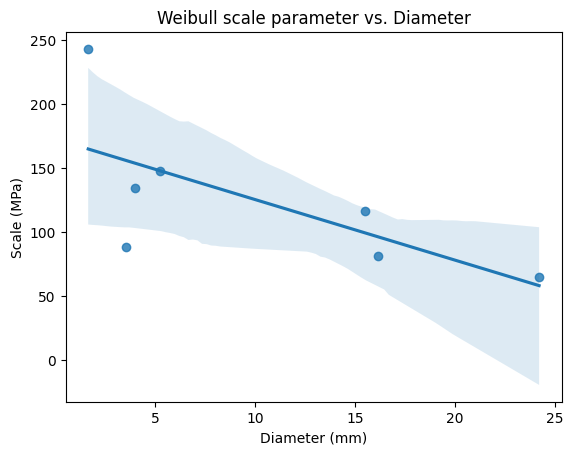

In [1586]:
ax = sns.regplot(data=gcc_data_anal, x="fracture_diameter_mean", y="Alpha")
ax.set(xlabel="Diameter (mm)", ylabel="Scale (MPa)", title="Weibull scale parameter vs. Diameter")


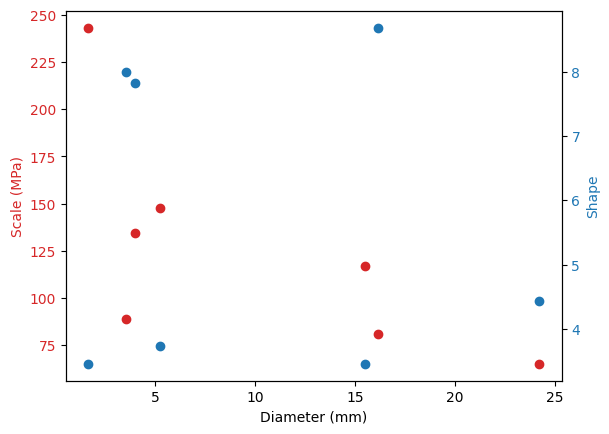

In [1587]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel("Diameter (mm)")
ax1.set_ylabel('Scale (MPa)', color=color)
ax1.scatter("fracture_diameter_mean", "Alpha", data=gcc_data_anal.dropna(), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Shape', color=color)  # we already handled the x-label with ax1
ax2.scatter("fracture_diameter_mean", "Beta", data=gcc_data_anal.dropna(), color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Size effect normalisation

## Functions

In [1588]:
def cylinder_SA(diameter: float, length: float) -> float: return np.pi * diameter * length
def cylinder_V(diameter: float, length: float) -> float: return np.pi * (diameter / 2)**2 * length

In [1589]:
def size_effect_normalize(original_prob: float, original_size: float, standard_size: float) -> float:
    size_ratio = standard_size / original_size
    return 1 - (1 - original_prob)**size_ratio

In [1590]:
def normalize_data(data, standard_diameter, standard_length):
    standard_SA = cylinder_SA(standard_diameter, standard_length)
    standard_V = cylinder_V(standard_diameter, standard_length)

    data["Fail Prob V Adj"] = data.apply(lambda row: size_effect_normalize(row["Fail Prob"], row["volume"], standard_V), axis=1)
    data["Fail Prob SA Adj"] = data.apply(lambda row: size_effect_normalize(row["Fail Prob"], row["surface_area"], standard_SA), axis=1)

    return data

In [1591]:
def fit_normalized_data(data, method):
    if method == "V":
        method_column = "Fail Prob V Adj"
    elif method == "SA":
        method_column = "Fail Prob SA Adj"
    else:
        raise("Please choose a valid method, volume (V) or surface area (SA)")
    
    least_squares_data = data[["fracture_stress", method_column]].dropna()

    stress = least_squares_data["fracture_stress"].to_numpy()
    fail_prob = least_squares_data[method_column].to_numpy()

    x = np.log(stress)
    y = np.log(-np.log(1-fail_prob))

    m, c = np.polyfit(x, y, 1)

    beta = m
    alpha = np.exp(-c / beta)

    return (alpha, beta)
    

In [1592]:
def plot_normalized_weibull(data, analysed_data, alpha, beta, method):
    if method == "V":
        method_column = "Fail Prob V Adj"
        method_title = "volume"
    elif method == "SA":
        method_column = "Fail Prob SA Adj"
        method_title = "surface_area"
    else:
        raise("Please choose a valid method, volume (V) or surface area (SA)")

    normalise_unique_series = data.dropna()["series"].unique()
    
    normal_dist_x = np.linspace(40, 300, 200)
    normalised_dist_y = Weibull_Distribution(alpha=alpha, beta=beta).CDF(xvals=normal_dist_x, show_plot=False)

    plt.clf()
    fig, ax = plt.subplots(layout="constrained")
    ax.plot(normal_dist_x, normalised_dist_y, label="Best Fit")

    color = iter(plt.cm.Dark2(np.linspace(0, 1, len(normalise_unique_series))))
    title_text = method_title + " Normalised Weibull Probability\nScale= %.2f MPa  Shape= %.2f" % (alpha, beta)

    for i, letter in enumerate(normalise_unique_series):
        plot_data = data.loc[data["series"] == letter]


        c = next(color)

        avg_diameter = analysed_data.loc[letter, "fracture_diameter_mean"]
        legend_text = "%s series: ~%.2f mm" % (letter, avg_diameter)
        ax.scatter(data=plot_data, x="fracture_stress", y=method_column, marker="^", color=c, label=legend_text)

    ax.set_yscale('function', functions=(axes_transforms.weibull_forward, axes_transforms.weibull_inverse))
    ax.set_xscale("log")

    probability_plot_xyticks()
    probability_plot_xylims(normal_dist_x, normalised_dist_y, "weibull")

    ax.set_xlabel("Failure Stress (MPa)")
    ax.set_ylabel("Probability of failure")
    ax.set_title(title_text)

    ax.grid(zorder=2)
    ax.set_axisbelow(True)
    ax.legend()
    plt.gcf().set_size_inches(6, 9)
    plt.show()

## Perform Analysis

In [1593]:
gcc_data_clean = normalize_data(gcc_data_clean, 3.5, 185)

gcc_data_clean

,sample,fracture_load,fracture_stress,fracture_diameter,...,Fail Check,Fail Prob,Fail Prob V Adj,Fail Prob SA Adj
0,B1,46.7887,67.761,5.23,...,67.761,0.0673077,0.0307243,0.0455604
1,B2,85.8979,170.977,5.28,...,170.977,0.740385,0.447093,0.590954
2,B3,54.1228,102.886,5.3,...,102.886,0.163462,0.0748839,0.111185
3,B4,64.6418,122.189,5.31,...,122.189,0.451923,0.229917,0.327238
4,B5,78.9588,174.763,5.09,...,174.763,0.836538,0.575299,0.712176
5,B6,57.2761,116.623,5.18,...,116.623,0.355769,0.181874,0.257025
6,B7,68.1001,128.726,5.31,...,128.726,0.548077,0.291826,0.407564
7,B8,80.9788,162.4,5.24,...,162.4,0.644231,0.369395,0.498573
8,B9,56.073,108.539,5.22,...,108.539,0.259615,0.126401,0.182531
9,B10,92.3955,179.794,5.32,...,179.794,0.932692,0.689003,0.83057


### On volume

In [1594]:
alpha_V, beta_V = fit_normalized_data(gcc_data_clean, "V")

print("alpha = ", alpha_V, "\n")
print("beta = ", beta_V)

alpha =  137.88731287210177 

beta =  2.9253324123431144


<Figure size 640x480 with 0 Axes>

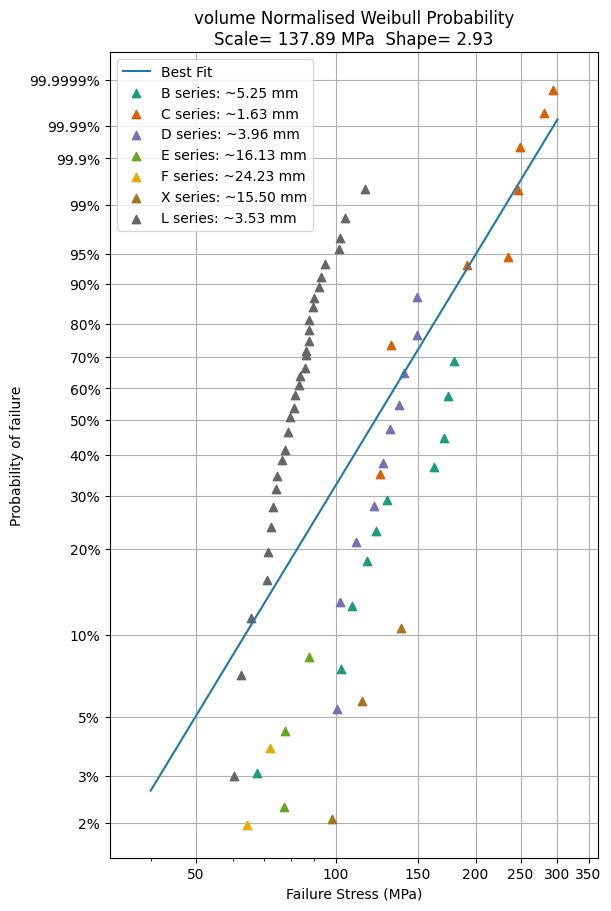

In [1595]:
plot_normalized_weibull(gcc_data_clean, gcc_data_anal, alpha_V, beta_V, "V")

### On Surface Area

In [1596]:
alpha_SA, beta_SA = fit_normalized_data(gcc_data_clean, "SA")

print("m = ", alpha_SA, "\n")
print("c = ", beta_SA)

m =  137.37737997129807 

c =  2.0621244279097777


<Figure size 640x480 with 0 Axes>

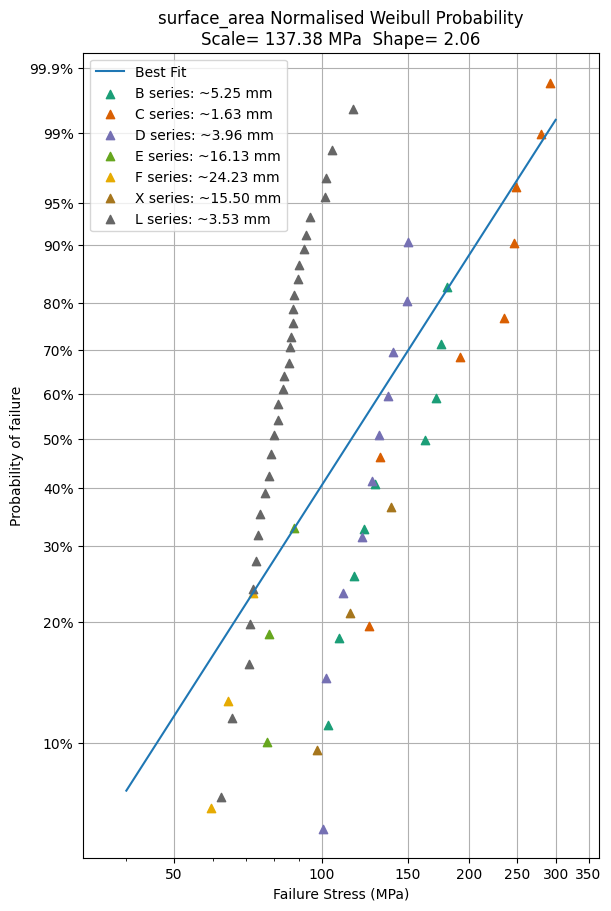

In [1597]:
plot_normalized_weibull(gcc_data_clean, gcc_data_anal, alpha_SA, beta_SA, "SA")

# Stiffness Analysis

## Functions

In [1598]:
def circle_inertia(dia): return (np.pi * dia ** 4) / 64

def solve_for_modulus (slope, dia, support_span, load_span):
    lever = (support_span - load_span) / 2
    inertia = circle_inertia(dia)
    return (slope / (12 * inertia)) * (3 * support_span * lever **2 - 4 * lever**3) / 1000

In [1599]:
gcc_data_clean["elastic_mod"] = gcc_data_clean.apply(lambda x: solve_for_modulus(x["stiff_slope"], x["fracture_diameter"], x["support_span"], x["load_span"]), axis=1)

gcc_data_clean

,sample,fracture_load,fracture_stress,fracture_diameter,...,Fail Prob,Fail Prob V Adj,Fail Prob SA Adj,elastic_mod
0,B1,46.7887,67.761,5.23,...,0.0673077,0.0307243,0.0455604,36.152
1,B2,85.8979,170.977,5.28,...,0.740385,0.447093,0.590954,42.4083
2,B3,54.1228,102.886,5.3,...,0.163462,0.0748839,0.111185,35.4182
3,B4,64.6418,122.189,5.31,...,0.451923,0.229917,0.327238,37.6611
4,B5,78.9588,174.763,5.09,...,0.836538,0.575299,0.712176,46.3326
5,B6,57.2761,116.623,5.18,...,0.355769,0.181874,0.257025,41.4542
6,B7,68.1001,128.726,5.31,...,0.548077,0.291826,0.407564,38.9492
7,B8,80.9788,162.4,5.24,...,0.644231,0.369395,0.498573,43.3907
8,B9,56.073,108.539,5.22,...,0.259615,0.126401,0.182531,40.1393
9,B10,92.3955,179.794,5.32,...,0.932692,0.689003,0.83057,40.8347


In [1600]:
# gcc_data_clean.to_excel("Rod_test_output.xlsx")

In [1601]:
stiff_anal = gcc_data_clean[["elastic_mod", "series"]].groupby("series").agg(['mean', "std"])
stiff_anal.columns = stiff_anal.columns.map('_'.join)

stiff_anal["elastic_mod_CV"] = stiff_anal["elastic_mod_std"] / stiff_anal["elastic_mod_mean"] * 100

stiff_anal

,elastic_mod_mean,elastic_mod_std,elastic_mod_CV
series,,,
B,40.274,3.36407,8.35294
C,88.0265,17.674,20.078
D,45.0531,2.88235,6.39768
E,17.2149,2.46355,14.3105
F,11.147,2.88827,25.9108
G,11.6128,NaN,NaN
H,7.00895,NaN,NaN
I,8.56661,NaN,NaN
J,3.45579,NaN,NaN


In [1602]:
gcc_data_anal = pd.merge(gcc_data_anal, stiff_anal, on="series")

gcc_data_anal

,fracture_diameter_mean,fracture_diameter_std,fracture_stress_mean,fracture_stress_std,...,Beta,elastic_mod_mean,elastic_mod_std,elastic_mod_CV
series,,,,,,,,,
B,5.248,0.0725412,133.466,37.1229,...,3.73272,40.274,3.36407,8.35294
C,1.6275,0.115851,218.925,63.7101,...,3.46282,88.0265,17.674,20.078
D,3.962,0.052451,126.708,18.0425,...,7.82771,45.0531,2.88235,6.39768
E,16.13,0.0559762,77.1536,9.06919,...,8.67882,17.2149,2.46355,14.3105
F,24.225,0.0957427,59.5653,12.8028,...,4.43198,11.147,2.88827,25.9108
G,20.04,NaN,69.2194,NaN,...,NaN,11.6128,NaN,NaN
H,23.95,NaN,74.6243,NaN,...,NaN,7.00895,NaN,NaN
I,33.38,NaN,66.0997,NaN,...,NaN,8.56661,NaN,NaN
J,27,NaN,29.4361,NaN,...,NaN,3.45579,NaN,NaN


In [1603]:
# gcc_data_anal.to_excel("Rod_test_analysis.xlsx")

[Text(0.5, 0, 'Diameter (mm)'),
 Text(0, 0.5, 'Elastic modulus (GPa)'),
 Text(0.5, 1.0, 'Elastic modulus vs. Diameter')]

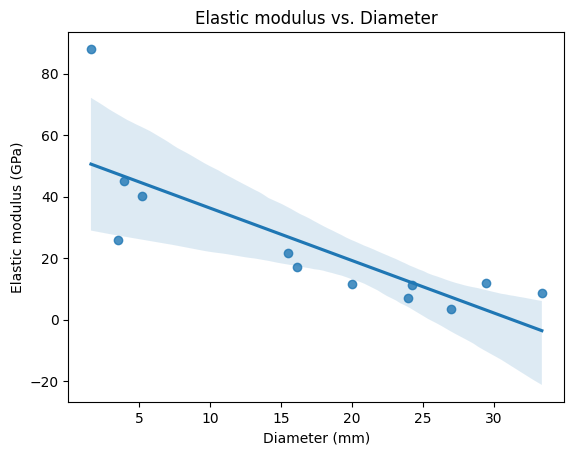

In [1604]:
ax = sns.regplot(data=gcc_data_anal, x="fracture_diameter_mean", y="elastic_mod_mean")
ax.set(xlabel="Diameter (mm)", ylabel="Elastic modulus (GPa)", title="Elastic modulus vs. Diameter")